In [1]:
# See if transformer is any better/faster than convolution+attention at regressing PNC age data

# Bad subjects
# Bad IDs: 605515760919, 601983541597

# Load split

import pickle

badIDs = [605515760919, 601983541597]

with open('../../Splits/RegressionAllTasks/split1.bin', 'rb') as f:
    d = pickle.load(f)
    train = []
    trainDirty = d['train']
    test = []
    testDirty = d['test']
    
    # Remove bad subjects
    for subj in trainDirty:
        if subj['ID'] not in badIDs:
            train.append(subj)
            
    for subj in testDirty:
        if subj['ID'] not in badIDs:
            test.append(subj)
    
print(len(train))
print(len(test))
print(train[0])

466
156
{'meta': {'AgeInMonths': 146, 'Gender': 'F', 'Ethnicity': 'AFRICAN', 'AgeGroupID': 2, 'AgeGroupEdge1': 144, 'AgeGroupEdge2': 180}, 'rest': '30', 'nback': '31', 'emoid': '31', 'ID': 600262185931}


In [2]:
# Load data

def loadTimeseries(_id, _dir):
    ts = None
    with open('{:s}/{:d}.bin'.format(_dir, _id), 'rb') as f:
        ts = pickle.load(f)
    return ts

train_rest_ts = [loadTimeseries(int(subj['nback']), '../../nback_fmri_power264/timeseries') for subj in train]
# train_nback_ts = [loadTimeseries(int(subj['nback']), '../../nback_fmri_power264/timeseries') for subj in train]
# train_emoid_ts = [loadTimeseries(int(subj['emoid']), '../../emoid_fmri_power264/timeseries') for subj in train]

test_rest_ts = [loadTimeseries(int(subj['nback']), '../../nback_fmri_power264/timeseries') for subj in test]
# test_nback_ts = [loadTimeseries(int(subj['nback']), '../../nback_fmri_power264/timeseries') for subj in test]
# test_emoid_ts = [loadTimeseries(int(subj['emoid']), '../../emoid_fmri_power264/timeseries') for subj in test]

print('Complete')

Complete


In [3]:
# Normalize data

import numpy as np

def normalizeSubjects(subjects):
    for i in range(len(subjects)):
        subj = subjects[i]
        subj -= np.mean(subj, axis=1, keepdims=True)@np.ones([1,subj.shape[1]])
        subj /= np.std(subj, axis=1, keepdims=True)@np.ones([1,subj.shape[1]])
        if np.sum(np.isnan(subj)) > 0:
            print(i)
        if np.sum(np.isinf(subj)) > 0:
            print(i)

normalizeSubjects(train_rest_ts)
# normalizeSubjects(train_nback_ts)
# normalizeSubjects(train_emoid_ts)

normalizeSubjects(test_rest_ts)
# normalizeSubjects(test_nback_ts)
# normalizeSubjects(test_emoid_ts)

print('Complete')

Complete


In [4]:
# Create labels (ages)

y_train = np.vstack([subj['meta']['AgeInMonths'] for subj in train])
y_test = np.vstack([subj['meta']['AgeInMonths'] for subj in test])

print('Complete')

Complete


In [5]:
# Apply PCA

from sklearn.decomposition import PCA

pca = PCA(80)
pca.fit(np.vstack([subj.T for subj in train_rest_ts]))

train_rest_ts_pca = [pca.transform(subj.T).T for subj in train_rest_ts]
test_rest_ts_pca = [pca.transform(subj.T).T for subj in test_rest_ts]

print('Complete')

Complete


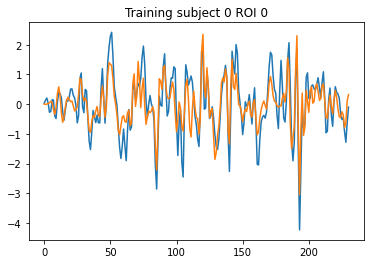

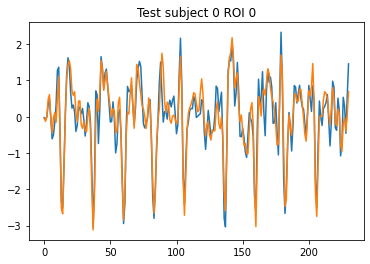

In [6]:
# Test PCA

import matplotlib.pyplot as plt

reconTrain = pca.inverse_transform(train_rest_ts_pca[0].T).T
reconTest = pca.inverse_transform(test_rest_ts_pca[0].T).T

plt.plot(train_rest_ts[0][0,:])
plt.plot(reconTrain[0,:])
plt.title('Training subject 0 ROI 0')
plt.show()

plt.plot(test_rest_ts[0][0,:])
plt.plot(reconTest[0,:])
plt.title('Test subject 0 ROI 0')
plt.show()

In [7]:
# Torch

import torch
import torch.nn as nn
import torch.nn.functional as F

# cuda = torch.device('cuda')

train_rest_ts_torch = [torch.from_numpy(subj).T.float() for subj in train_rest_ts_pca]
test_rest_ts_torch = [torch.from_numpy(subj).T.float() for subj in test_rest_ts_pca]

# print(train_rest_ts_torch[0].device)
print('Complete')

Complete


In [17]:
# Simple transformer
# Our data is already in the channels x patches format

nt = train_rest_ts_torch[0].shape[0]
nrois = 80

class MyTrans(nn.Module):
    def __init__(self):
        super(MyTrans, self).__init__()
        self.tfmr = nn.Transformer(d_model=nrois, dim_feedforward=1024)
    
    def forward(self, src, tgtAge):
        # Permute src from (nb x nt x nrois) to (nt x nb x nrois)
        src = src.permute(1,0,2)
        # tgtAge is (nb) and transformer tgt is (1 x nb x nrois)
        nb = tgtAge.shape[0]
        tgt = torch.zeros(1,nb,nrois)
        tgt[0,0:nb,:] = tgtAge.reshape(nb,1)*torch.ones(1,nrois)
        out = self.tfmr(src, tgt)
        return out[0,0:nb,0]
    
trans = MyTrans()
optim = torch.optim.Adam(trans.parameters(), lr=1e-3)

print('Complete')

Complete


In [18]:
import random

N = len(train_rest_ts_torch)-1
running = 0
nEpoch = 3000
pPeriod = 10
nBatch = 10

for epoch in range(nEpoch):
    batch = []
    truth = torch.zeros(nBatch)
    for i in range(nBatch):
        idx = random.randint(0,N)
        subj = train_rest_ts_torch[idx]
        batch.append(subj.unsqueeze(0))
        truth[i] = y_train[idx,0]
    optim.zero_grad()
    pred = trans(torch.cat(batch), truth).view(nBatch)
    loss = torch.sum((truth-pred)**2)
    loss.backward()
    optim.step()
    running += loss
    if epoch % pPeriod == 0 or epoch == nEpoch-1:
        if epoch != 0:
            running = running/pPeriod
        print('epoch {:d} loss={:f}'.format(epoch, running))
        running = 0

print('Finished training')

epoch 0 loss=397569.312500
epoch 10 loss=288638.343750
epoch 20 loss=309213.468750
epoch 30 loss=280673.500000
epoch 40 loss=296796.656250
epoch 50 loss=285660.125000
epoch 60 loss=314215.812500
epoch 70 loss=322783.687500
epoch 80 loss=306063.250000
epoch 90 loss=310032.937500
epoch 100 loss=319888.781250
epoch 110 loss=318912.281250
epoch 120 loss=309907.593750
epoch 130 loss=304121.062500
epoch 140 loss=306377.625000
epoch 150 loss=319458.375000
epoch 160 loss=302123.000000
epoch 170 loss=297710.406250
epoch 180 loss=312924.437500
epoch 190 loss=311755.843750
epoch 200 loss=307374.000000


KeyboardInterrupt: 